# Bootstrapping

Due to some issues we noticed when replicating Galvao et al's asymptotic variance estimator and test statistic, we turn to bootstrapping to try to come up with bootstrap bias estimate, bootstrap standard errors, and an alternative Wald-type test.

## Notebook setup

In [63]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import chi2
from scipy import stats
import torch
from tqdm import tqdm
import sys 
sys.path.append('../')
from utils import utils
sys.executable

'/Users/fanghema/Desktop/aaSTAT_5200/STAT_5200_final_project/env/bin/python'

In [2]:
data = pd.read_csv(
    '../data/processed/data_extended.csv',
    index_col=0,
    parse_dates=True
)

factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
assets = [col for col in data.columns if col != 'RF' and col not in factors]
data['Quarter'] = data.index.to_period("Q")

beta_loading, returns_df, realized_covariance, residuals = utils.calculate_factor_loading(
    data, 
    factors=factors, 
    assets=assets
)

excess_returns = (
    returns_df
    .groupby("Quarter")
    .sum()
    [assets]
    .T
    .values
)
industries = beta_loading.index.get_level_values(0).unique().tolist()
factors = beta_loading.index.get_level_values(1).unique().tolist()

N = len(industries)
K = len(factors)
T = beta_loading.shape[1]
R = 3

beta_hat_np = np.zeros((N, K, T))

for i, asset in enumerate(industries):
    for j, factor in enumerate(factors):
        beta_hat_np[i, j, :] = beta_loading.loc[(asset, factor)].values

beta_hat_np.shape

(47, 5, 250)

## Using Jackknife

In [ ]:
p = N * (K + 1)
jackknife_eta_estimates = np.zeros((T, p))

for t in range(T):
    if (t % 10) == 0:
        print(f"Processing {t} out of {T}")

    time_mask = np.ones(T, dtype=bool)
    time_mask[t] = False 

    beta_hat_subset = beta_hat_np[:, :, time_mask]          # (N, K, T-1)
    excess_returns_subset = excess_returns[:, time_mask]    # (N, T-1)

    eta_jk, G_jk, beta_star_jk, objective_jk = utils.penalty_based_minimization(
        beta_hat=beta_hat_subset,
        excess_returns=excess_returns_subset,
        N=N,
        K=K,
        R=R,
        T=T-1,           # updated sample size
        n_iter=500,
    )

    jackknife_eta_estimates[t, :] = eta_jk.reshape(p)

Now, we do a full sample estimation.

In [7]:
eta, G, beta_star, objective = utils.iterative_convergence(
    beta_hat=beta_hat_np,
    excess_returns=excess_returns,
    N=N,
    K=K,
    R=R,
    T=T,
    n_iter=2000,
    verbose=False
)

p = N * (K + 1)
eta_hat_full = eta.reshape(p)

In [42]:
# Jackknife mean
eta_jk_mean = jackknife_eta_estimates.mean(axis=0)

# Jackknife bias
jk_bias = (T - 1) * (eta_jk_mean - eta_hat_full)

# Jackknife covariance
eta_centered = jackknife_eta_estimates - eta_jk_mean
jk_cov = ((T - 1) / T) * (eta_centered.T @ eta_centered)

In [43]:
eta_centered.shape

(250, 282)

In [44]:
print(np.linalg.inv(jk_cov).min())
print(np.linalg.inv(jk_cov).max())

-1.863547211797388e+17
1.638447607959742e+17


In [45]:
p = N * (K + 1)

eta_mean = eta.mean(axis=0)
eta_centered = eta - eta_mean
d_vec = eta_centered.reshape(-1)
print("Typical |d|:", np.median(np.abs(d_vec)))

print("Diag(jk_cov) head:", np.diag(jk_cov)[:10])

rough_var = jackknife_eta_estimates.var(axis=0)[:10]
print("Naive var across jk replicates (first 10):", rough_var)

Typical |d|: 0.050935989443553834
Diag(jk_cov) head: [1.26641957e+01 9.11005233e-03 2.70422503e-02 5.87296361e-02
 7.69373618e-02 1.26184372e-01 5.24237287e+01 7.07177949e-02
 2.01213236e-01 4.07243362e-02]
Naive var across jk replicates (first 10): [5.08602237e-02 3.65865555e-05 1.08603415e-04 2.35861993e-04
 3.08985389e-04 5.06764545e-04 2.10537063e-01 2.84007209e-04
 8.08085283e-04 1.63551551e-04]


In [40]:
def _flatten_eta(eta: np.ndarray) -> np.ndarray:
    """
    vec(eta) stacking assets one after another.
    eta: (N, K+1)
    returns: (N*(K+1),)
    """
    return eta.reshape(-1)


def wald_full_homogeneity_jackknife(
    eta: np.ndarray,
    jk_cov: np.ndarray,
    N: int,
    K: int
):
    """
    Wald-type test for joint homogeneity:
        H0: all intercepts equal AND all slopes equal across assets.
    Here we use centered eta_i (deviation from cross-sectional mean)
    and jackknife covariance of vec(eta).

    Returns:
        gamma_ad: standardized test statistic ~ N(0,1) under H0
        W: chi-square statistic ~ χ²_q under H0
        p_value: p-value based on N(0,1) approximation for gamma_ad
    """
    p = N * (K + 1)
    assert eta.shape == (N, K + 1)
    assert jk_cov.shape == (p, p)

    # Center eta across assets
    eta_mean = eta.mean(axis=0)          # (K+1,)
    eta_centered = eta - eta_mean        # (N, K+1)
    d_vec = _flatten_eta(eta_centered)   # (p,)

    V = jk_cov
    V_inv = np.linalg.pinv(V)

    W = float(d_vec.T @ V_inv @ d_vec)

    q = (N - 1) * (K + 1)

    gamma_ad = (W - q) / np.sqrt(2 * q)

    p_val = 2 * (1 - norm.cdf(abs(gamma_ad)))

    return gamma_ad, W, p_val


def wald_intercept_homogeneity_jackknife(
    eta: np.ndarray,
    jk_cov: np.ndarray,
    N: int,
    K: int
):
    """
    Wald-type test for:
        H0: α_i = 0  for all i (intercepts jointly zero).

    Uses jackknife covariance submatrix corresponding to intercepts.
    """
    p = N * (K + 1)
    assert eta.shape == (N, K + 1)
    assert jk_cov.shape == (p, p)

    alpha = eta[:, 0]                   # (N,)

    # indices of intercepts in vec(eta): 0, K+1, 2(K+1), ...
    alpha_idx = np.arange(0, p, K + 1)

    V_eta = jk_cov
    V_alpha = V_eta[np.ix_(alpha_idx, alpha_idx)]   # (N, N)
    V_alpha_inv = np.linalg.pinv(V_alpha)

    W = float(alpha.T @ V_alpha_inv @ alpha)

    q = N 

    gamma_a = (W - q) / np.sqrt(2 * q)
    p_val = 2 * (1 - norm.cdf(abs(gamma_a)))

    return gamma_a, W, p_val


def wald_slope_homogeneity_jackknife(
    eta: np.ndarray,
    jk_cov: np.ndarray,
    N: int,
    K: int
):
    """
    Wald-type test for:
        H0: λ_i = λ  for all i  (all slope vectors equal across assets).

    We work with cross-sectionally centered slopes, so under H0
    the mean of vec(centered slopes) is approximately 0, and we
    use the jackknife covariance of those components.
    """
    p = N * (K + 1)
    assert eta.shape == (N, K + 1)
    assert jk_cov.shape == (p, p)

    slopes = eta[:, 1:]                              # (N, K)
    slopes_centered = slopes - slopes.mean(axis=0)   # (N, K)
    slopes_vec = slopes_centered.reshape(N * K)      # (NK,)

    slope_idx = []
    for i in range(N):
        for j in range(K):
            slope_idx.append(i * (K + 1) + 1 + j)
    slope_idx = np.array(slope_idx)

    V_eta = jk_cov
    V_lambda = V_eta[np.ix_(slope_idx, slope_idx)]   # (NK, NK)
    V_lambda_inv = np.linalg.pinv(V_lambda)

    W = float(slopes_vec.T @ V_lambda_inv @ slopes_vec)

    q = (N - 1) * K 

    gamma_lambda = (W - q) / np.sqrt(2 * q)
    p_val = 2 * (1 - norm.cdf(abs(gamma_lambda)))

    return gamma_lambda, W, p_val

In [41]:
gamma_a_lam_jk, W_a_lam_jk, _ = wald_full_homogeneity_jackknife(
    eta=eta,
    jk_cov = jk_cov,
    N = N,
    K = K
)

gamma_a_jk, W_a_jk, _= wald_intercept_homogeneity_jackknife(
    eta=eta,
    jk_cov = jk_cov,
    N = N,
    K = K
)

gamma_lam_jk, W_lam_jk, _= wald_slope_homogeneity_jackknife(
    eta=eta,
    jk_cov = jk_cov,
    N = N,
    K = K
)

print(gamma_a_lam_jk)
print(gamma_a_jk)
print(gamma_lam_jk)

1829.0568303859861
7.00146195513254
3411.160745721216


### Using jackknife for full empirical test

In [ ]:
factor_options = [
    ['Mkt-RF'],
    ['Mkt-RF', 'SMB', 'HML'],
    ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'],
]
R_options = [1, 2, 5]
sample_period_options = [
    ('1963-01-01', '2025-12-31'),
    ('1963-01-01', '1983-01-01'),
    ('1973-01-01', '1993-01-01'),
    ('1983-01-01', '2003-01-01'),
    ('1993-01-01', '2013-01-01'),
    ('2003-01-01', '2023-01-01'),
]

results = pd.DataFrame(
    index=pd.MultiIndex.from_product([
        list(map(tuple, factor_options)),   # convert lists → tuples
        R_options,
        sample_period_options
    ]),
    columns=['gamma_a_lam', 'gamma_a', 'gamma_lam']
)

print(f"Total combinations: {results.shape[0]}")
counter = 0

for factors in factor_options:
    K = len(factors)
    for R in R_options:
        for sample_period in sample_period_options:
            print(f"Processing {counter}/{results.shape[0]}: {factors} - {R} - {sample_period}")
            data_slice = data.loc[
                (data.index > sample_period[0]) &
                (data.index < sample_period[1])
            ]
            beta_loading, returns_df, realized_covariance, residuals = utils.calculate_factor_loading(
                data_slice, 
                factors=factors, 
                assets=assets
            )

            excess_returns = returns_df.groupby("Quarter").sum()[assets].T.values
            industries = beta_loading.index.get_level_values(0).unique().tolist()
            factors_names = beta_loading.index.get_level_values(1).unique().tolist()

            N = len(industries)
            K = len(factors)
            T = beta_loading.shape[1]

            beta_hat_np = np.zeros((N, K, T))

            for i, asset in enumerate(industries):
                for j, factor in enumerate(factors):
                    beta_hat_np[i, j, :] = beta_loading.loc[(asset, factor)].values

            
            eta, G, beta_star, objective = utils.iterative_convergence(
                beta_hat_np, 
                excess_returns,
                N = N,
                K = K, 
                R = R,
                T = T,
                n_iter=2000
            )

            avar = utils.estimate_avar(
                beta_hat=beta_hat_np,
                excess_returns=excess_returns,
                eta=eta,
                G=G,
                beta_star=beta_star,
                realized_covariance=realized_covariance,
                residuals=residuals,
                N = N,
                K = K, 
                R = R,
                T = T,
            )

                
            gamma_a_lambda = utils.full_homogeneity_test(
                eta = eta, 
                avar = avar,
                N = N,
                K = K, 
                T = T
            )

            gamma_a = utils.intercept_homogeneity_test(
                eta = eta, 
                avar = avar,
                N = N,
                K = K, 
                T = T
            )

            gamma_lambda = utils.slope_homogeneity_test(
                eta = eta, 
                avar = avar,
                N = N,
                K = K, 
                T = T
            )
            print(f"Test statistics")
            print(f"gamma_a_lam: {gamma_a_lambda}")
            print(f"gamma_a: {gamma_a}")
            print(f"gamma_lam: {gamma_lambda}")

            results.loc[(
                tuple(factors), R, sample_period
            )] = np.asarray([
                gamma_a_lambda,
                gamma_a,
                gamma_lambda
            ])
            counter += 1
            print(f"===========================")




## Testing for Type I error rate

In [85]:
def run_mc_jackknife(
    N=20, K=3, R=1, T=200,
    MC_REPS=100,
    n_iter_est=400,
    seed=12345,
    verbose=False,
    heterogeneiy_strength = 0.0
):
    rng = np.random.default_rng(seed)

    # store statistics
    gamma_full_list = []
    gamma_a_list = []
    gamma_lam_list = []

    for rep in range(MC_REPS):
        rep_seed = rng.integers(1_000_000)

        # heterogeneity_strength = 0
        beta_true, r, realized_cov, residuals, G_true, beta_star_true, lambda_true = utils.simulate_dgp(
            N=N, K=K, R=R, T=T,
            heterogeneity_strength=heterogeneiy_strength,
            seed=rep_seed
        )

        eta_hat, G_hat, beta_star_hat, obj = utils.iterative_convergence(
            beta_true,   
            r,
            N=N, K=K, R=R, T=T,
            n_iter=n_iter_est,
            verbose=False
        )

        p = N * (K + 1)
        jk_eta = np.zeros((T, p))

        for t in range(T):
            mask = np.ones(T, dtype=bool)
            mask[t] = False

            beta_sub = beta_true[:, :, mask]
            r_sub = r[:, mask]

            eta_jk, _, _, _ = utils.iterative_convergence(
                beta_sub, r_sub,
                N=N, K=K, R=R, T=T-1,
                n_iter=n_iter_est,
                verbose=False
            )

            jk_eta[t, :] = eta_jk.reshape(p)

        jk_mean = jk_eta.mean(axis=0)

        diffs = jk_eta - jk_mean
        jk_cov = (T - 1) / T * (diffs.T @ diffs)

        gamma_full, _, _ = wald_full_homogeneity_jackknife(
            eta=eta_hat,
            jk_cov=jk_cov,
            N=N,
            K=K
        )
        gamma_a, _, _ = wald_intercept_homogeneity_jackknife(
            eta=eta_hat,
            jk_cov=jk_cov,
            N=N,
            K=K
        )
        gamma_lam, _, _ = wald_slope_homogeneity_jackknife(
            eta=eta_hat,
            jk_cov=jk_cov,
            N=N,
            K=K
        )

        gamma_full_list.append(gamma_full)
        gamma_a_list.append(gamma_a)
        gamma_lam_list.append(gamma_lam)

        if (rep+1) % 2 == 0 and verbose:
            print(f"MC rep {rep+1}/{MC_REPS} complete.")

    return np.array(gamma_full_list), np.array(gamma_a_list), np.array(gamma_lam_list)

In [ ]:
gamma_full, gamma_a, gamma_lam = run_mc_jackknife(
    N=20, K=3, R=1, T=200,
    MC_REPS=100,
    verbose=True
)

def type1_error(g):
    return np.mean(np.abs(g) > 1.96)

In [79]:
print("Type-I error (full test):", type1_error(gamma_full))
print("Type-I error (alpha test):", type1_error(gamma_a))
print("Type-I error (lambda test):", type1_error(gamma_lam))

Type-I error (full test): 0.995
Type-I error (alpha test): 0.105
Type-I error (lambda test): 0.61


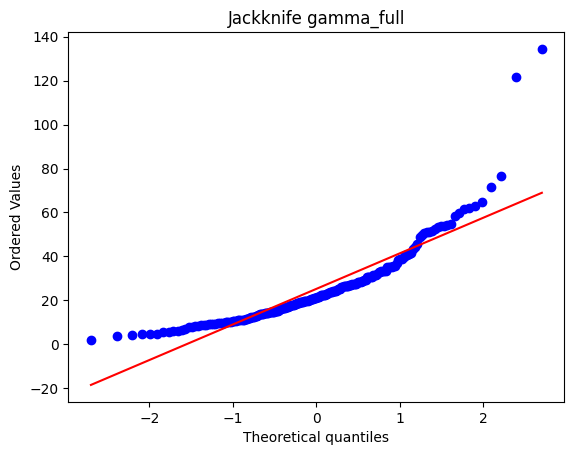

In [60]:
stats.probplot(gamma_full, dist="norm", plot=plt)
plt.title("Jackknife gamma_full")
plt.show()

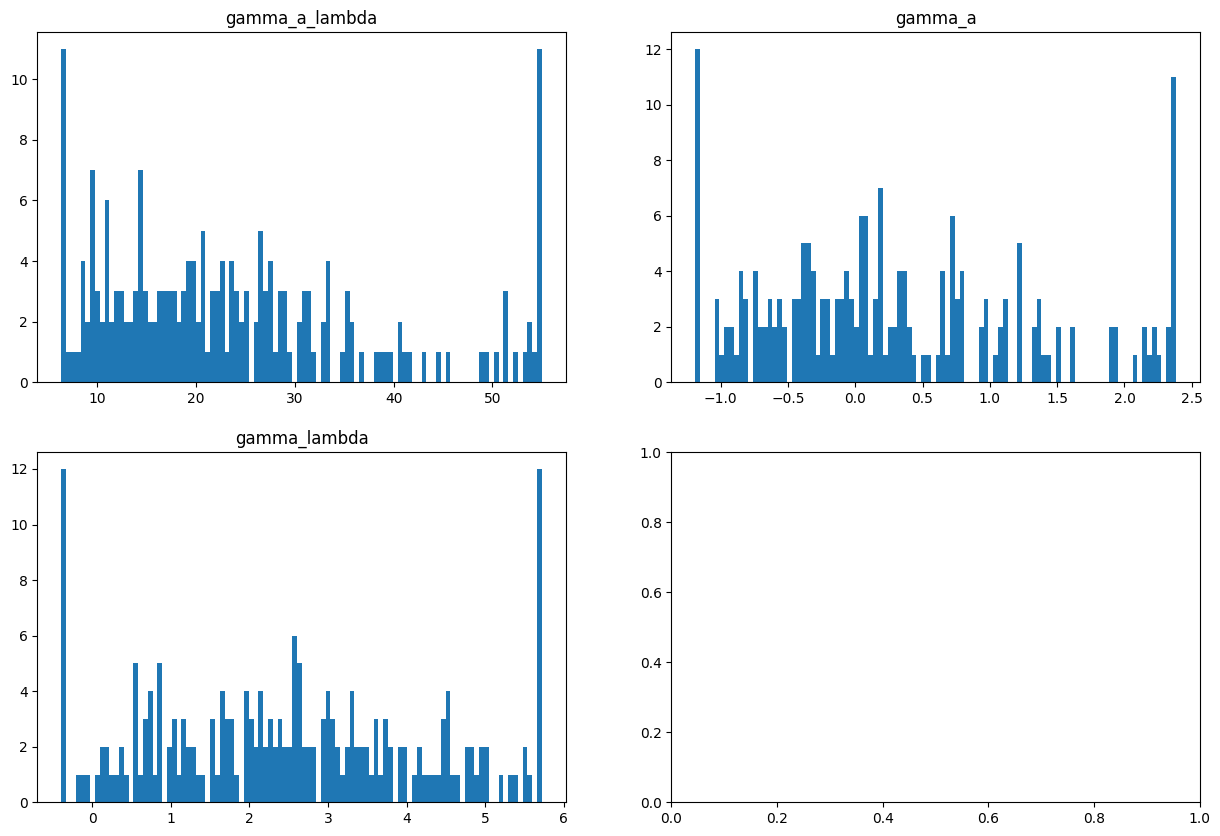

In [58]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10))
axes = np.ravel(axes)
labels = ['gamma_a_lambda', 'gamma_a', 'gamma_lambda']

for i, test_statistic in enumerate([gamma_full, gamma_a, gamma_lam]):
    axes[i].hist(
        utils.clean(test_statistic),
        bins = 100,
    )
    axes[i].set_title(labels[i])

In [87]:
gamma_h1_full, gamma_h1_a, gamma_h1_lam = run_mc_jackknife(
    N=20, K=3, R=1, T=200,
    MC_REPS=200,
    verbose=True,
    heterogeneiy_strength=1.0
)

def reject_rate(g):
    return np.mean(np.abs(g) > 1.96)


print("Power (full test):", reject_rate(gamma_h1_full))
print("Power (alpha test):", reject_rate(gamma_h1_a))
print("Power (lambda test):", reject_rate(gamma_h1_lam))

MC rep 2/200 complete.
MC rep 4/200 complete.
MC rep 6/200 complete.
MC rep 8/200 complete.
MC rep 10/200 complete.
MC rep 12/200 complete.
MC rep 14/200 complete.
MC rep 16/200 complete.
MC rep 18/200 complete.
MC rep 20/200 complete.
MC rep 22/200 complete.
MC rep 24/200 complete.
MC rep 26/200 complete.
MC rep 28/200 complete.
MC rep 30/200 complete.
MC rep 32/200 complete.
MC rep 34/200 complete.
MC rep 36/200 complete.
MC rep 38/200 complete.
MC rep 40/200 complete.
MC rep 42/200 complete.
MC rep 44/200 complete.
MC rep 46/200 complete.
MC rep 48/200 complete.
MC rep 50/200 complete.
MC rep 52/200 complete.
MC rep 54/200 complete.
MC rep 56/200 complete.
MC rep 58/200 complete.
MC rep 60/200 complete.
MC rep 62/200 complete.
MC rep 64/200 complete.
MC rep 66/200 complete.
MC rep 68/200 complete.
MC rep 70/200 complete.
MC rep 72/200 complete.
MC rep 74/200 complete.
MC rep 76/200 complete.
MC rep 78/200 complete.
MC rep 80/200 complete.
MC rep 82/200 complete.
MC rep 84/200 comple

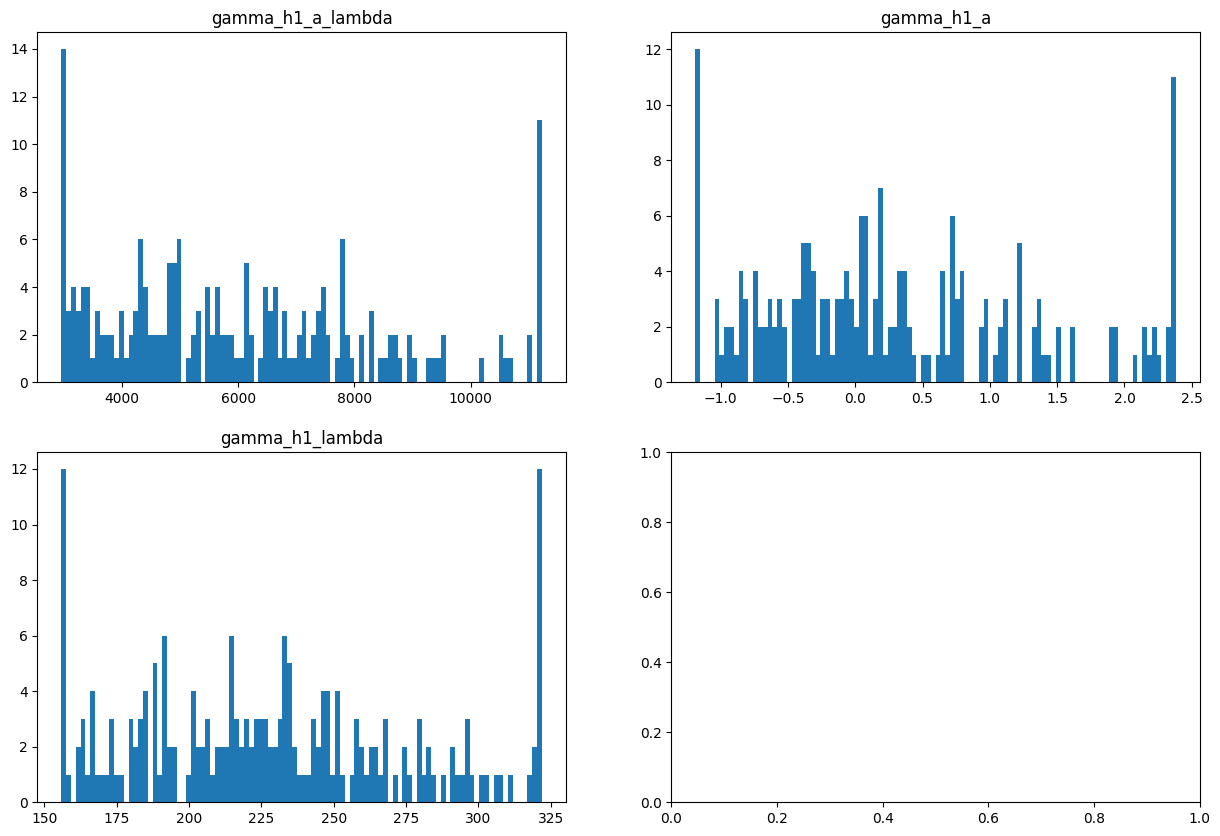

In [88]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10))
axes = np.ravel(axes)
labels = ['gamma_h1_a_lambda', 'gamma_h1_a', 'gamma_h1_lambda']

for i, test_statistic in enumerate([gamma_h1_full, gamma_h1_a, gamma_h1_lam]):
    axes[i].hist(
        utils.clean(test_statistic),
        bins = 100,
    )
    axes[i].set_title(labels[i])

## Jackknife Attempt #2

In [76]:
def mc_null_jackknife_theoretical_avar_tests(
    N=20, K=3, R=1, T=200,
    MC_REPS=50,
    n_iter_est=400,
    seed=1234,
    heterogeneity_strength=0.0
):
    rng = np.random.default_rng(seed)

    gamma_full_obs      = np.zeros(MC_REPS)
    gamma_alpha_obs     = np.zeros(MC_REPS)
    gamma_lambda_obs    = np.zeros(MC_REPS)

    gamma_full_resample   = np.zeros((MC_REPS, T))
    gamma_alpha_resample  = np.zeros((MC_REPS, T))
    gamma_lambda_resample = np.zeros((MC_REPS, T))

    for mc in range(MC_REPS):
        print(f"Processing {mc}", end = '\r')
        rep_seed = rng.integers(1_000_000_000)

        # Simulate under the NULL
        beta_true, r, realized_cov, residuals, G_true, beta_star_true, lambda_true = utils.simulate_dgp(
            N=N, K=K, R=R, T=T,
            heterogeneity_strength=heterogeneity_strength,
            seed=rep_seed
        )

        # FULL-SAMPLE ESTIMATE
        eta_full, G_full, beta_star_full, obj_full = utils.iterative_convergence(
            beta_hat=beta_true,
            excess_returns=r,
            N=N, K=K, R=R, T=T,
            n_iter=n_iter_est,
            verbose=False
        )

        avar_full = utils.estimate_avar(
            beta_hat=beta_true,
            excess_returns=r,
            eta=eta_full,
            G=G_full,
            beta_star=beta_star_full,
            realized_covariance=realized_cov,
            residuals=residuals,
            N=N, K=K, R=R, T=T
        )

        # Full-sample test stats
        gamma_full_obs[mc] = utils.full_homogeneity_test(eta_full, avar_full, N, K, T)
        gamma_alpha_obs[mc] = utils.intercept_homogeneity_test(eta_full, avar_full, N, K, T)
        gamma_lambda_obs[mc] = utils.slope_homogeneity_test(eta_full, avar_full, N, K, T)

        # jackknife resampling
        for t in range(T):

            mask = np.ones(T, dtype=bool)
            mask[t] = False

            beta_sub = beta_true[:, :, mask]   # (N, K, T-1)
            r_sub = r[:, mask]                 # (N, T-1)
            realized_cov_sub = realized_cov[:, :, mask]
            residuals_sub = residuals[:, :, mask]

            # Re-estimate parameters on the resampled dataset
            eta_jk, G_jk, beta_star_jk, obj_jk = utils.iterative_convergence(
                beta_hat=beta_sub,
                excess_returns=r_sub,
                N=N, K=K, R=R, T=T-1,
                n_iter=n_iter_est,
                verbose=False
            )

            avar_jk = utils.estimate_avar(
                beta_hat=beta_sub,
                excess_returns=r_sub,
                eta=eta_jk,
                G=G_jk,
                beta_star=beta_star_jk,
                realized_covariance=realized_cov_sub,
                residuals=residuals_sub,
                N=N, K=K, R=R, T=T-1
            )

            # Test statistics for leave-one-out
            gamma_full_resample[mc, t] = utils.full_homogeneity_test(eta_jk, avar_jk, N, K, T-1)
            gamma_alpha_resample[mc, t] = utils.intercept_homogeneity_test(eta_jk, avar_jk, N, K, T-1)
            gamma_lambda_resample[mc, t] = utils.slope_homogeneity_test(eta_jk, avar_jk, N, K, T-1)

    return (
        gamma_full_obs, gamma_alpha_obs, gamma_lambda_obs,
        gamma_full_resample, gamma_alpha_resample, gamma_lambda_resample
    )

In [69]:
gamma_full_obs, gamma_alpha_obs, gamma_lambda_obs, \
gamma_full_resample, gamma_alpha_resample, gamma_lambda_resample \
    = mc_null_jackknife_theoretical_avar_tests()


Size (full test): 0.1
Size (alpha test): 0.08
Size (lambda test): 0.06


In [70]:
def size_from_resamples_two_sided(g_obs, g_res):
    """
    g_obs: shape (MC_REPS,)
    g_res: shape (MC_REPS, T) — each row is T resampled statistics
    """
    lower = np.percentile(g_res, 2.5, axis=1)   # per MC rep
    upper = np.percentile(g_res, 97.5, axis=1)

    reject = (g_obs < lower) | (g_obs > upper)

    return np.mean(reject)

print("Size (full test):", size_from_resamples_two_sided(gamma_full_obs, gamma_full_resample))
print("Size (alpha test):", size_from_resamples_two_sided(gamma_alpha_obs, gamma_alpha_resample))
print("Size (lambda test):", size_from_resamples_two_sided(gamma_lambda_obs, gamma_lambda_resample))

Size (full test): 0.08
Size (alpha test): 0.06
Size (lambda test): 0.04


In [81]:
gamma_h1_full_obs, gamma_h1_alpha_obs, gamma_h1_lambda_obs, \
gamma_h1_full_resample, gamma_h1_alpha_resample, gamma_h1_lambda_resample \
    = mc_null_jackknife_theoretical_avar_tests(
        heterogeneity_strength=10
    )


In [82]:
print("When heterogeneity is 1.0")
print("Power (full test):", size_from_resamples_two_sided(gamma_h1_full_obs, gamma_h1_full_resample))
print("Power (alpha test):", size_from_resamples_two_sided(gamma_h1_alpha_obs, gamma_h1_alpha_resample))
print("Power (lambda test):", size_from_resamples_two_sided(gamma_h1_lambda_obs, gamma_h1_lambda_resample))

When heterogeneity is 1.0
Power (full test): 0.02
Power (alpha test): 0.02
Power (lambda test): 0.02
